# Simulated Data Ingest

Read the simulated images from a zip file, split into stratified train/test sets and write out to tfrecord files on the PRP CEPH/S3 cluster with public access so they can be used from Colab

In [52]:
import os
import re
import zipfile
import numpy as np
import tensorflow as tf

In [2]:
# Switch to data directory for storing download and tfrecords
!mkdir -p ~/data/braingeneers
os.chdir(os.path.expanduser("~/data/braingeneers"))

Found 49 different labels


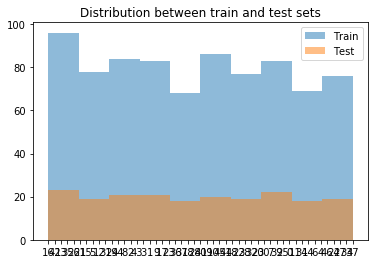

In [65]:
# Stratify into train and test sets
with zipfile.ZipFile("mltest-cropped.zip", "r") as f:
    paths = [path for path in filter(lambda p: p.endswith(".png"), f.namelist())]
    labels = [re.findall(r".*?\/\w+_(\d+)", path)[0] for path in paths]
    
print("Found {} different labels".format(len(set(labels))))
        
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(paths, labels, stratify=labels, test_size=0.20)

import matplotlib.pyplot as plt

plt.hist(y_train, alpha=0.5, label='Train')
plt.hist(y_test, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Distribution between train and test sets")
plt.show()

In [71]:
def write_dataset(path, paths, labels):
    with zipfile.ZipFile("mltest-cropped.zip", "r") as f:
        with tf.python_io.TFRecordWriter(path) as writer:
            for path, label in zip(paths, labels):
                writer.write(tf.train.Example(features=tf.train.Features(
                    feature = {
                        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[f.read(path)])),
                        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[int(label)]))
                    })).SerializeToString())

write_dataset("mltest-cropped-train.tfrecord", X_train, y_train)
write_dataset("mltest-cropped-test.tfrecord", X_test, y_test)

# Upload to S3

These files are now accessible publicly external to the PRP at:

  https://s3.nautilus.optiputer.net/braingeneers/simulation/mltest-cropped.zip

  https://s3.nautilus.optiputer.net/braingeneers/simulation/mltest-cropped-train.tfrecord
  
  https://s3.nautilus.optiputer.net/braingeneers/simulation/mltest-cropped-test.tfrecord


    
and internal to the PRP at the endpoint rook-ceph-rgw-rooks3.rook

In [110]:
# Use the aws cli's rsync like sync command to push up to PRP S3/CEPH
!aws --profile {os.getenv("AWS_PROFILE")} --endpoint {os.getenv("AWS_S3_ENDPOINT")} \
    s3 sync . s3://braingeneers/simulation --acl public-read

upload: ./mltest-cropped-test.tfrecord to s3://braingeneers/simulation/mltest-cropped-test.tfrecord
upload: ./mltest-cropped.zip to s3://braingeneers/simulation/mltest-cropped.zip
upload: ./mltest-cropped-train.tfrecord to s3://braingeneers/simulation/mltest-cropped-train.tfrecord


In [111]:
!aws --profile {os.getenv("AWS_PROFILE")} --endpoint {os.getenv("AWS_S3_ENDPOINT")} \
    s3 ls s3://braingeneers/simulation/

2018-11-03 04:51:16    6327552 mltest-cropped-test.tfrecord
2018-11-03 04:51:17   25141200 mltest-cropped-train.tfrecord
2018-11-03 04:51:17   31577599 mltest-cropped.zip
